<h2><center>Tree Segmentation</center></h2>

![](https://media.discordapp.net/attachments/703945836614123561/866940481263108146/banner.jpg?width=1439&height=277)

I used [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) for the image segmentation.

# Setting up Environment

### Downloading Dataset

So we will first need to download the python library by AIcrowd that will allow us to download the dataset by just inputting the API key. 

In [1]:
# !pip install --user aicrowd-cli

In [2]:
!aicrowd login --api-key API_KEY

API Key valid
Saved API Key successfully!


In [1]:
# Downloading the Dataset
!rm -rf data
!mkdir data
!aicrowd ds dl -c tree-segmentation -o data

In [2]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

### Downloading & Importing Libraries

Here we are going to use [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) which is a really popular library providing a tons of different segmentation models for pytorch including basic unets to DeepLabV3! 

In [5]:
# !pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
# !pip3 install --user pillow==8.2.0
# !pip3 install --user natsort
# !pip3 install --user timm==0.4.12
# !pip3 install --user efficientnet_pytorch==0.6.3
# !pip3 install --user pretrainedmodels==0.7.4
# !pip3 install --user git+https://github.com/qubvel/segmentation_models.pytorch 

In [3]:
# Pytorch 
import torch
from torch import nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

# Reading Dataset, vis and miscellaneous
import math
from PIL import Image
import matplotlib.pyplot as plt
import os
import shutil
import random
import numpy as np
from tqdm.notebook import tqdm
import cv2
from natsort import natsorted

# Training phase ⚙️

Get validation set

In [4]:
def seed_everything(seed):
  os.environ["PL_GLOBAL_SEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

seed_everything(1)

In [5]:
indexes = [i for i in range(5000)]
val_idxes = random.sample(indexes, 500)
val_idxes[0]

1100

In [6]:
!rm -rf data/val
os.mkdir('data/val')
os.mkdir('data/val/image')
os.mkdir('data/val/segmentation')
for idx in val_idxes:
  shutil.move(f'data/train/image/{idx}.jpg', 'data/val/image')
  shutil.move(f'data/train/segmentation/{idx}.png', 'data/val/segmentation')

## Creating the Dataloader

Here, we are simply create a class for pytorch to load the dataset and then to put into the model 

In [7]:
from torchvision import transforms
import torchvision.transforms.functional as F

class TreeSegmentationDataset(Dataset):
    def __init__(self, img_directory=None, label_directory=None, mode='train', img_transforms=None, mutual_transforms=None):
        

        self.img_directory = img_directory
        self.label_directory = label_directory            

        # If the image direcotry is valid      
        if img_directory != None:
          self.img_list = natsorted(os.listdir(img_directory))
          self.label_list = natsorted(os.listdir(label_directory))

        self.mode = mode
        self.img_transforms = img_transforms
        self.mutual_transforms = mutual_transforms

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        # Reading the image
        img = Image.open(os.path.join(self.img_directory, self.img_list[idx]))
        
        if self.mode == 'train' and self.img_transforms is not None:
          img = self.img_transforms(img)
          
        preprocessing = transforms.Compose(
          [
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ]
        )
        img = preprocessing(img)

        if self.mode == 'train':
          mask = Image.open(os.path.join(self.label_directory, self.label_list[idx]))
          mask = transforms.ToTensor()(mask).int()
          if self.mutual_transforms is not None:
            img, mask = self.mutual_transforms(img, mask)
          return img, mask

        elif self.mode == 'val':
          mask = Image.open(os.path.join(self.label_directory, self.label_list[idx]))
          mask = transforms.ToTensor()(mask).int()
          return img, mask
        
        else:
          return img

In [8]:
class RandomHorizontalVerticalFlip(object):
  def __init__(self, v_flip, h_flip):
    self.v_flip = v_flip
    self.h_flip = h_flip

  def __call__(self, image, target):
    if random.random() < self.v_flip:
      image = F.vflip(image)
      target = F.vflip(target)
    if random.random() < self.h_flip:
      image = F.hflip(image)
      target = F.hflip(target)
    return image, target

# train_img_transforms = transforms.ColorJitter(brightness=0.1, contrast=0.1)
# train_mutual_transforms = RandomHorizontalVerticalFlip(v_flip=0.5, h_flip=0.5)
train_img_transforms = None
train_mutual_transforms = None

In [9]:
# Creating the training dataset
train_dataset = TreeSegmentationDataset(img_directory="data/train/image", label_directory="data/train/segmentation", mode='train', img_transforms=train_img_transforms, mutual_transforms=train_mutual_transforms)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_dataset = TreeSegmentationDataset(img_directory="data/val/image", label_directory="data/val/segmentation", mode='val')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, drop_last=True)

In [10]:
# Reading the image and corrosponding segmentation
image_batch, segmentation_batch = next(iter(train_loader))

image_batch.shape, segmentation_batch.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 1, 512, 512]))

## Creating the Model

Here we will get setting up the model architecture, optimizer and loss.

In [14]:
model = smp.UnetPlusPlus(
    encoder_name='resnet50', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
    in_channels=3
)

In [15]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

## Training the Model

In [16]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [17]:
max_score = 0

for i in range(0, 30): 
  print('\nEpoch: {}'.format(i))
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(val_loader)
  curr_score = valid_logs['fscore']

  if max_score < curr_score:
    max_score = curr_score
    torch.save(model, 'best.pth')
    print('Model saved!')

  torch.save(model, 'last.pth')


Epoch: 0
train:   0%|          | 0/562 [00:00<?, ?it/s]

/home/featurize/work/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid: 100%|██████████| 62/62 [00:21<00:00,  2.83it/s, dice_loss - 0.06439, fscore - 0.937] 
Model saved!

Epoch: 1
valid: 100%|██████████| 62/62 [00:22<00:00,  2.81it/s, dice_loss - 0.06136, fscore - 0.9392]
Model saved!

Epoch: 2
valid: 100%|██████████| 62/62 [00:22<00:00,  2.81it/s, dice_loss - 0.05425, fscore - 0.9461]
Model saved!

Epoch: 3
valid: 100%|██████████| 62/62 [00:22<00:00,  2.81it/s, dice_loss - 0.05291, fscore - 0.9474]
Model saved!

Epoch: 4
valid: 100%|██████████| 62/62 [00:22<00:00,  2.78it/s, dice_loss - 0.05116, fscore - 0.9491]
Model saved!

Epoch: 5
valid: 100%|██████████| 62/62 [00:22<00:00,  2.75it/s, dice_loss - 0.04971, fscore - 0.9505]
Model saved!

Epoch: 6
valid: 100%|██████████| 62/62 [00:22<00:00,  2.77it/s, dice_loss - 0.04815, fscore - 0.952] 
Model saved!

Epoch: 7
valid: 100%|██████████| 62/62 [00:23<00:00,  2.67it/s, dice_loss - 0.04737, fscore - 0.9528]
Model saved!

Epoch: 8
valid: 100%|██████████| 62/62 [00:23<00:00,  2.63it/s, dice_loss - 0.047

## Finetune

In [12]:
model = torch.load("best.pth")

In [13]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0005),
])

In [14]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [15]:
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=30)
max_score = 0

for i in range(0, 30): 
  print('\nEpoch: {}'.format(i))
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(val_loader)
  curr_score = valid_logs['fscore']

  if max_score < curr_score:
    max_score = curr_score
    torch.save(model, 'best.pth')
    print('Model saved!')
    
  scheduler.step()

  torch.save(model, 'last.pth')


Epoch: 0
train:   0%|          | 0/562 [00:00<?, ?it/s]

/home/featurize/work/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid: 100%|██████████| 62/62 [00:22<00:00,  2.77it/s, dice_loss - 0.03983, fscore - 0.9602]
Model saved!

Epoch: 1
valid: 100%|██████████| 62/62 [00:22<00:00,  2.81it/s, dice_loss - 0.03951, fscore - 0.9605]
Model saved!

Epoch: 2
valid: 100%|██████████| 62/62 [00:22<00:00,  2.77it/s, dice_loss - 0.03958, fscore - 0.9604]

Epoch: 3
valid: 100%|██████████| 62/62 [00:22<00:00,  2.80it/s, dice_loss - 0.03948, fscore - 0.9605]
Model saved!

Epoch: 4
valid: 100%|██████████| 62/62 [00:22<00:00,  2.82it/s, dice_loss - 0.03933, fscore - 0.9607]
Model saved!

Epoch: 5
valid: 100%|██████████| 62/62 [00:22<00:00,  2.81it/s, dice_loss - 0.03918, fscore - 0.9608]
Model saved!

Epoch: 6
valid: 100%|██████████| 62/62 [00:22<00:00,  2.82it/s, dice_loss - 0.03921, fscore - 0.9608]

Epoch: 7
valid: 100%|██████████| 62/62 [00:21<00:00,  2.84it/s, dice_loss - 0.03912, fscore - 0.9609]
Model saved!

Epoch: 8
valid: 100%|██████████| 62/62 [00:21<00:00,  2.82it/s, dice_loss - 0.03909, fscore - 0.9609]
Model

KeyboardInterrupt: 

# Submitting Results 📄

Okay, this is the last section 😌 , let's get out testing results from the model real quick and submit our prediction directly using AIcrowd CLI

In [16]:
model = torch.load("best.pth")

In [17]:
test_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)
test_logs = test_epoch.run(val_loader)
print(test_logs['fscore'])

valid: 100%|██████████| 62/62 [00:22<00:00,  2.76it/s, dice_loss - 0.03842, fscore - 0.9616]
0.9616008910440632


## Loading the Test Dataset

In [18]:
test_dataset = TreeSegmentationDataset(img_directory="data/test/image", mode='test')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=False)

## Making the Predictions

In [19]:
predictions = []

# Ground though each test batch and adding predictions  
for images in tqdm(test_loader):
  prediction = model.predict(images.to(DEVICE))
  predictions.extend(prediction.cpu().numpy())

In [20]:
!rm -rf segmentation
!mkdir segmentation

for n, img in tqdm(enumerate(predictions)):

  img = img[0]

  img = np.where(img >= 0.5, 255, 0)

  # Making sure the pixels are only 0 and 255 in the image. 
  img = Image.fromarray(img.astype(np.uint8))

  img.save(os.path.join("segmentation", f"{n}.png"))

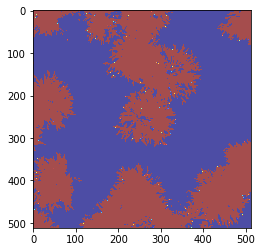

In [21]:
image = predictions[-1][0]
plt.figure()
plt.imshow(image, 'jet', interpolation='none', alpha=0.7)
plt.show()


**Note : Please make sure that there should be folder `segmentation` your working directory before submitting the predictions**

## Uploading the Results